# 03-Basic CNN and PyTorch

## Convolutional Neural Network

In computer vision, a convolutional neural network(CNN) is a well-known deep learning technique that is widely used by the state-of-the-art(SOTA) vision models such as AlexNet, ResNet and YOLO. CNNs are specifically designed for image related tasks such as classification, segmentation, object detection and 3D reconstruction.  

In contrast to artificial neural network(ANN), convolutional layers use small filters(kernels) to extract the features from images. Each filter from a CNN consists of a set of trainable parameters that are shared in order to reduce the number of parameters.  Weight sharing in CNNs means that the same set of learnable parameters (weights and biases) is used for all spatial locations of the input when applying a filter. This design allows CNNs to efficiently learn and detect features throughout the input data while maintaining a manageable number of parameters.

<img src="img/cnn.gif" alt="CNN GIF" width="500px" style="float: center" />

#### CNN Explainer

Before doing this tutorial, take a look at the [CNN Explainer](https://poloclub.github.io/cnn-explainer/). It gives beautiful illustrations of what's happening in a CNN at every level.

#### Kernel

In CNN, a kernel, also known as a filter, is a small matrix of learnable parameters that is used to perform a convolution operation on an input data volume, which is typically an image or a feature map from a previous layer. Kernels are one of the fundamental building blocks of CNNs and play a crucial role in feature extraction.  

A few things to know about kernel:  
1. **Kernel Size**  
A kernel can be a square or a rectangular matrix with small dimension. The commonly used sizes are 3x3 or 5x5.  

2. **Weights and Biases**  
Each element within the kernel is a learnable parameter, represented by a weight. Additionally, there is usually one bias term associated with each kernel. These weights and biases are learned during the training process through backpropagation.  

3. **Convolution Operation**  
The kernel is applied to the input data by sliding it over the input in a systematic way. Specifically, the kernel is placed on the top-left corner of the input, and a mathematical operation called convolution is performed by taking the **element-wise product** of the kernel and the overlapping portion of the input. These products are then **summed** to produce a single value, which forms a pixel in the output feature map.  

<img src="img/convolve.png" alt="Convolution" width="400px" />

4. **Feature Extraction**  
The purpose of the kernel is to extract specific features from the input data. Each kernel is designed to capture a particular pattern or feature, such as edges, textures, or other local characteristics.  

5. **Strides and Padding**  
The convolution operation can have parameters like stride and padding. Stride determines how much the kernel is moved horizontally and vertically with each step, affecting the spatial dimensions of the output feature map. Padding can be used to control the size of the output feature map and ensure that the spatial dimensions remain the same as the input. 

<img src="img/stride.png" alt="Stride" width="400px" />

6. **Multiple Kernels**  
In a single convolutional layer, multiple kernels are typically used. Each kernel captures a different feature, and together, they produce multiple feature maps as the layer's output. These feature maps collectively represent a set of learned features at different scales and orientations.  

7. **Stacking Convolutional Layers**  
CNNs often consist of multiple convolutional layers stacked together. These layers extract increasingly complex and abstract features as you move deeper into the network.  

<img src="img/stackedconvolution.png" alt="Stacked Convolution" width="400px" />


#### Connecting to Google Drive for Colab Users

For the students who use google colab for run the system. It is better to upload your dataset or weight, model into your drive. The colab system will be reset everytime when the system has log off.

Ok, let's mount the drive

In [ ]:
### for colab only, please uncomment.

# from google.colab import drive
# drive.mount('/content/gdrive')

# # Your root path in gdrive
# root_path = 'gdrive/your_directory_in_google_drive/'

In [2]:
### To create the folder
import os


print(os.getcwd()) ### Uncomment to get your current working directory
root_path = '/home/kuo/Desktop/DLCV/DLCV-Lab/DLCV-03-Basic_CNN_and_PyTorch/' ### Uncomment and modify your root path if you are using own laptop
lab_path =  root_path + 'lab03/'
if not os.path.exists(lab_path):
    print("No folder ", lab_path, 'exist. Creating a new folder...')
    os.mkdir(lab_path)
    print("New directory is created.")
else:
    print(vdo_path, 'exists, do nothing')

/home/kuo/Desktop/DLCV/DLCV-Lab/DLCV-03-Basic_CNN_and_PyTorch
No folder  /home/kuo/Desktop/DLCV/DLCV-Lab/DLCV-03-Basic_CNN_and_PyTorch/lab03/ exist. Creating a new folder...
New directory is created.


## Building CNN from Scratch using NumPy

This implementation referenced from [Ahmed Gad's tutorial](https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html).  

We will implement a very simple CNN in numpy. The model will have just three layers, a convolutional layer (conv for short), a ReLU activation layer, and max pooling. The major steps involved are as follows:  

1. Reading the input image.
2. Preparing filters.
3. Conv layer: Convolving each filter with the input image.
4. ReLU layer: Applying ReLU activation function on the feature maps (output of conv layer).
5. Max Pooling layer: Applying the pooling operation on the output of ReLU layer.
6. Stacking the conv, ReLU, and max pooling layers.

#### 1. Reading an Input Image

The following code reads an existing image using the `scikit-image` Python library and converts it into grayscale. You may need to `pip install scikit-image`.

Image dimensions: (300, 451, 3)


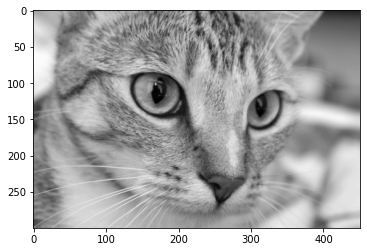

In [3]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
# import warnings
# warnings.filterwarnings("ignore")

# Read image
img = skimage.data.chelsea()
print('Image dimensions:', img.shape)

# Convert to grayscale
img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.show()

#### 2. Preparing Filters

Recall that a conv layer uses some number of convolution (actually cross correlation) filters, usually matching the number of channels in the input (1 in our case since the image is grayscale). Each kernel gives us one feature map (channel) in the result.

Let's make two 3 &times; 3 filters, using the horizontal and vertical Sobel edge filters:

In [4]:
l1_filters = np.zeros((2,3,3))
l1_filters[0, :, :] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])
l1_filters[1, :, :] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])

#### 3. Conv Layer

Let's perform the convolution operation to the input image with our filters.  

Before convolving, one important thing to notice is the calculation of the size of convolution output. We can memorize as the following:  

$$\text{output size} = \frac{\mathit{n - f + 2p}}{\mathit{s}}+1$$  

Where,  
$\mathit{n}$ = input size (width or height)  
$\mathit{f}$ = filter size  
$\mathit{p}$ = padding  
$\mathit{s}$ = stride  

P.S. The output size for each dimension have to be calculated separately if the input width and height are not equal.

In [5]:
# Perform stride 1 cross correlation of an image and a filter. We output the valid region only
# (no padding).
def convolve(img, conv_filter):
    stride = 1
    padding = 0
    filter_size = conv_filter.shape[1]
    results_dim = ((np.array(img.shape) - np.array(conv_filter.shape) + (2*padding))/stride) + 1
    result = np.zeros((int(results_dim[0]), int(results_dim[1])))
    
    for r in np.arange(0, img.shape[0] - filter_size + 1):
        for c in np.arange(0, img.shape[1]-filter_size + 1):          
            curr_region = img[r:r+filter_size,c:c+filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)
            result[r, c] = conv_sum
    
    return result       


# Perform convolution with a set of filters and return the result
def conv(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        if img.shape[-1] != conv_filters.shape[-1]:
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: 
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    # Prepare output
    feature_maps = np.zeros((img.shape[0]-conv_filters.shape[1]+1, 
                             img.shape[1]-conv_filters.shape[1]+1, 
                             conv_filters.shape[0]))

    # Perform convolutions
    for filter_num in range(conv_filters.shape[0]):
        curr_filter = conv_filters[filter_num, :]
# Our convolve function only handles 2D convolutions. If the input has multiple channels, we
# perform the 2D convolutions for each input channel separately then add them. If the input
# has just a single channel, we do the convolution directly.
        if len(curr_filter.shape) > 2:
            conv_map = convolve(img[:, :, 0], curr_filter[:, :, 0])
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map = conv_map + convolve(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
        else:
            conv_map = convolve(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map

    return feature_maps

2.26 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Convolutional feature maps shape: (298, 449, 2)


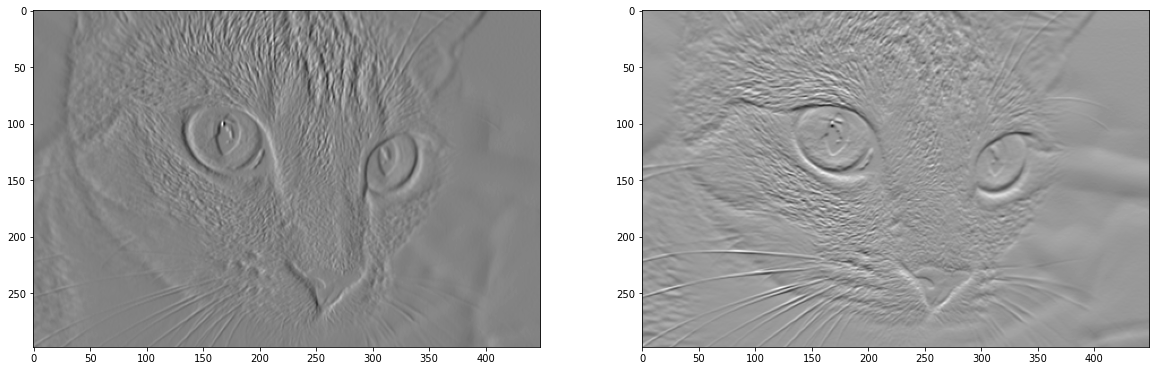

In [6]:
features = conv(img, l1_filters)
%timeit conv(img,l1_filters)

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()

#### 4. ReLU Layer

In [7]:
# ReLU activation function

def relu(feature_map):
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

#### 5. Max Pooling Layer

In [8]:
# Pooling layer with particular size and stride

def pooling(feature_map, size=2, stride=2):
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                         np.uint16((feature_map.shape[1]-size+1)/stride+1),
                         feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

Now let's try ReLU and pooling:

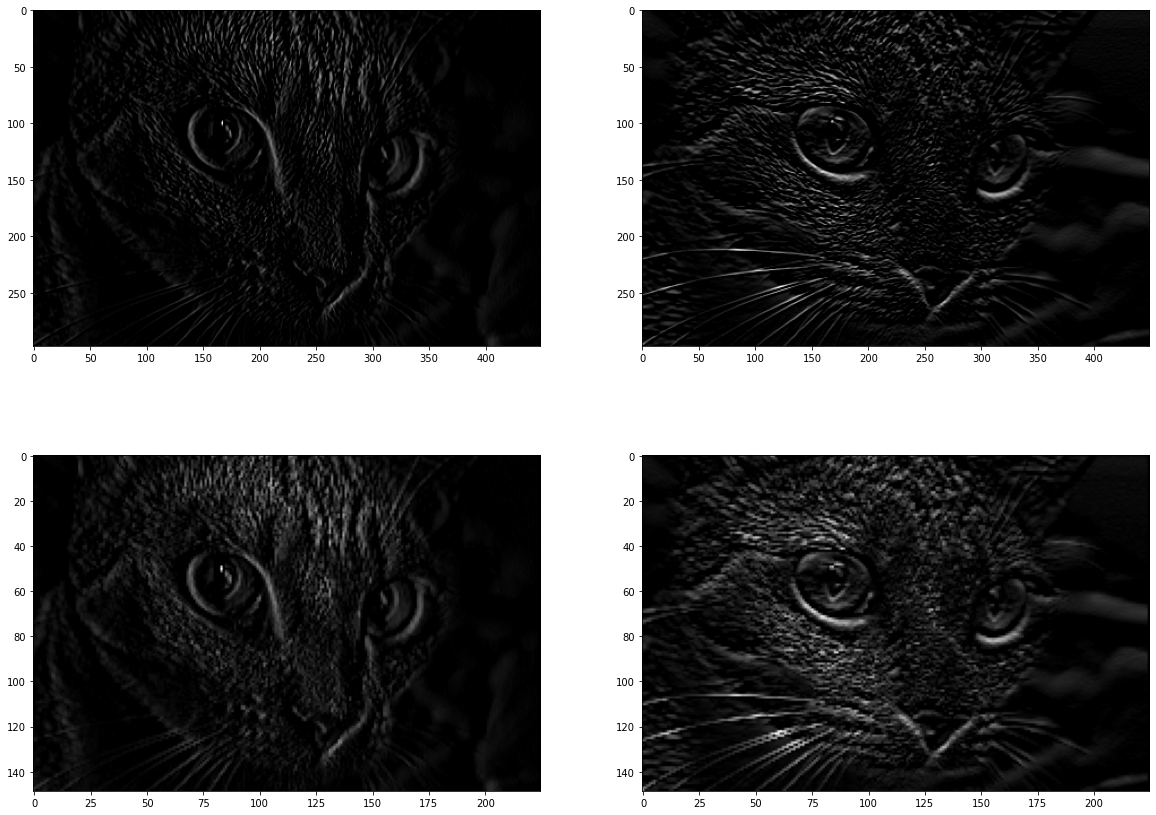

In [9]:
relued_features = relu(features)
pooled_features = pooling(relued_features)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
ax1.imshow(relued_features[:,:,0], cmap='gray')
ax2.imshow(relued_features[:,:,1], cmap='gray')
ax3.imshow(pooled_features[:,:,0], cmap='gray')
ax4.imshow(pooled_features[:,:,1], cmap='gray')
plt.show()

#### 6. Stacking Conv, ReLU and Maxpooling

We will continue stacking the conv, relu, maxpool sequence into layer by layer until we get the 3 convolutional layers.

In [10]:
# First conv layer

import sys

np.set_printoptions(threshold=sys.maxsize)

print("conv layer 1...")
l1_feature_maps = conv(img, l1_filters)
l1_feature_maps_relu = relu(l1_feature_maps)
l1_feature_maps_relu_pool = pooling(l1_feature_maps_relu, 2, 2)

# Second conv layer

print("conv layer 2...")
l2_filters = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool.shape[-1])
l2_feature_maps = conv(l1_feature_maps_relu_pool, l2_filters)
l2_feature_maps_relu = relu(l2_feature_maps)
l2_feature_maps_relu_pool = pooling(l2_feature_maps_relu, 2, 2)
#print(l2_feature_maps)

# Third conv layer

print("conv layer 3...")
l3_filters = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool.shape[-1])
l3_feature_maps = conv(l2_feature_maps_relu_pool, l3_filters)
l3_feature_maps_relu = relu(l3_feature_maps)
l3_feature_maps_relu_pool = pooling(l3_feature_maps_relu, 2, 2)

conv layer 1...
conv layer 2...
conv layer 3...


We have completed feed forward processing of 3 (conv, relu, maxpool) layers. Now let's try to visualize each layer output feature maps.

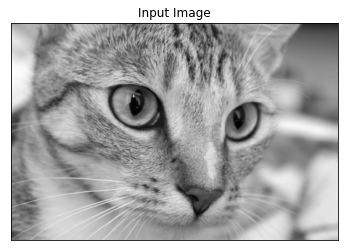

In [11]:
# Show results

fig0, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
plt.show()

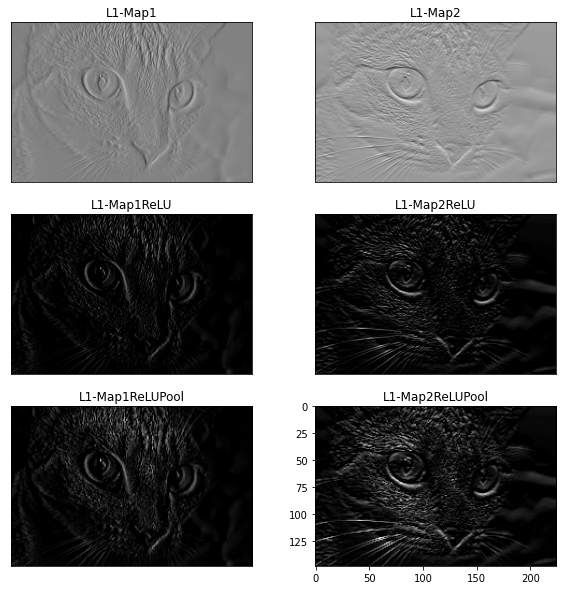

In [12]:
# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0, 0].imshow(l1_feature_maps[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_maps[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

plt.show()

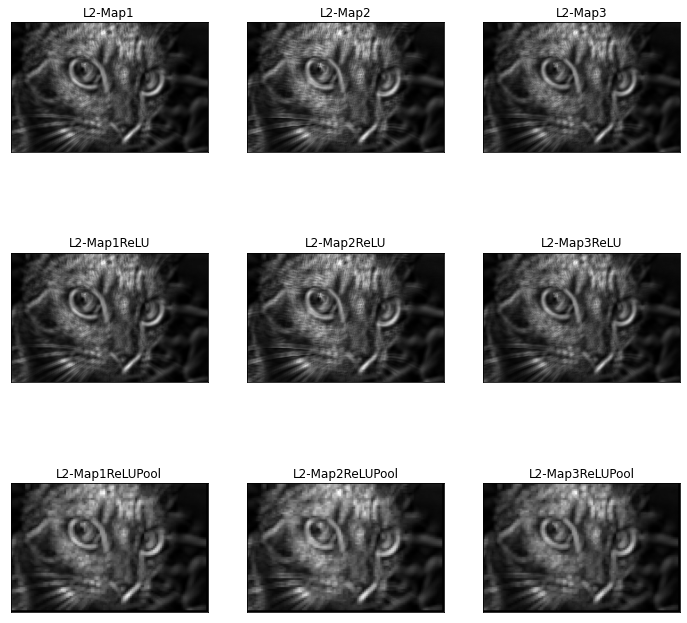

In [13]:
# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
fig2.set_figheight(12)
fig2.set_figwidth(12)
ax2[0, 0].imshow(l2_feature_maps[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_maps[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_maps[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_maps_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_maps_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")
plt.show()

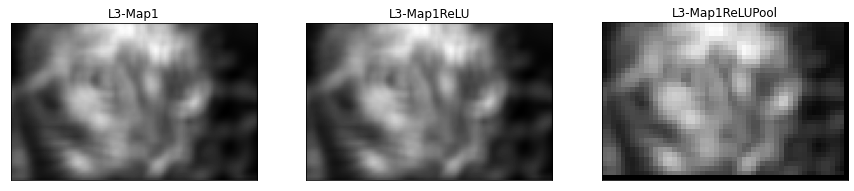

In [14]:
# Layer 3

fig3, ax3 = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(15)
fig3.set_figwidth(15)
ax3[0].imshow(l3_feature_maps[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")
plt.show()

We can see that at progressively higher layers of the network, we get coarser representations of the input. Since the filters at the later layers are random, they are not very structured, so we get a kind of blurring effect. These visualizations would be more meaningful in model with learned filters.

## CNNs in PyTorch

Now we'll do a more complete CNN example using PyTorch. We'll use the MNIST digits again. The example is based on [Anand Saha's PyTorch tutorial](https://github.com/anandsaha/deep.learning.with.pytorch).  

PyTorch has a few useful modules for us:

1. cuda: `Compute Unified Device Architecture` a GPU-based tensor computations
2. nn: Neural network layer implementations and backpropagation via autograd
3. torchvision: datasets, models, and image transformations for computer vision problems.  

torchvision itself includes several useful elements:  

1. datasets: Datasets are subclasses of torch.utils.data.Dataset. Some of the common datasets available are "MNIST," "COCO," and "CIFAR." In this example we will see how to load MNIST dataset using a custom subclass of the datasets class.
2. transforms - Transforms are used for image transformations. The MNIST dataset from torchvision is in PIL image.  

To convert MNIST images to tensors, we will use transforms.`ToTensor()`.


### Begin Your PyTorch

First of all, import torch libraries

In [15]:
import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

# The functional module contains helper functions for defining neural network layers as simple functions
import torch.nn.functional as F

### Important libraries

- torch - main package of pytorch. It provides a flexible N-dimensional array or Tensor, which supports basic routines for indexing, slicing, transposing, type-casting, resizing, sharing storage and cloning. This object is used by most other packages and thus forms the core object of the library. The Tensor also supports mathematical operations like max, min, sum, statistical distributions like uniform, normal and multinomial, and BLAS operations like dot product, matrix–vector multiplication, matrix–matrix multiplication and matrix product.
- torchvision - part of pytorch. The torchvision package consists of
    - popular datasets
    - model architectures
    - common image transformations for computer vision  
    
### Load the MNIST data

Next, let's load the data and transfrom the input elements (pixels) using torchvision, and do transformation to torch type and normalize the data using their mean over the entire training dataset is 0 and its standard deviation is 1.

In [ ]:
# Desired mean and standard deviation
mean = 0.0
stddev = 1.0

# Transform input image
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean), (stddev))])

# Download dataset to ./data
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)
# for colab user, use root_path
# mnist_train = datasets.MNIST(root_path + 'data', train=True, download=True, transform=transform)
# mnist_valid = datasets.MNIST(root_path + 'data', train=False, download=True, transform=transform)

Visualize sample images

In [ ]:
label = mnist_train[12][1]
print('Label of image above:', label)
img = mnist_train[12][0].numpy()
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

label = mnist_train[100][1]
print('Label of image above:', label)
img = mnist_train[100][0].numpy()
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

Create a `Dataloader` that loads the data and splits them into desired batches which are ready to feed into the model.

In [ ]:
# Reduce batch size if you get out-of-memory error
batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)


In [ ]:
for data, label in mnist_train_loader:
    print(data.shape)
    print(label.shape)
    break

### Create a Basic CNN Model

We use 2 convolutional layers followed by 2 fully connected layers. The input size of each image is (1,28,28). We will use stide of size 1 and padding of size 0. We called that `Valid` convolution. (Please also study on `Same` convolution)  

For first convolution layer we will apply 10 filters of size (5,5). CNN output formula  

$$\text{output size} = \frac{W - F + 2P}{S} + 1$$  
where,  
$W$ - input  
$F$ - filter size  
$P$ - padding size  
$S$ - stride size  

We get $\frac{(1,28,28) - (1,5,5) + (2*0)}{1} + 1$ for each filter, so for 10 filters we get output size of (24,24,10). The ReLU activation function is applied to the output of the first convolutional layer.

For the second convolutional layer, we apply 20 filters of size (5,5), giving us the output size of $\frac{(10,24,24) - (10,5,5) + (2*0)}{1} + 1$ = (20,20,20). (20,20,20). Maxpooling with a size of 2 is applied to the output of the second convolutional layer, thereby giving us an output size of (10,10,20). Then, the ReLU activation function is applied to the output of the maxpooling layer.

Next we have two fully connected layers. The input of the first fully connected layer is flattened output of $10*10*20 = 2000$, with 50 nodes. The fc second layer is the output layer and has 10 nodes.

#### Important Terms (for PyTorch)

**Tensor** - any matrix arrays which use for calculation, you can call input, output, weight as any tensors. In CNNs, we use "input tensor" as input; i.e. image, and "output tensor" as output.

**Kernel** - filter tensor, or weight tensor. In computer vision, we might call mask tensor or mask matrix.

**Channel** - number of depth in tensor, so sometime we call **depth** in 2D images. (Notice that the term **depth** is changed when the dimension of the image is 3D volumetric)

**Feature** - Specific characteristic information for using in **dense layers** or **fully connect layers**.

**Feature extraction** - the process of transforming raw data into numerical features that can be processed while preserving the information in the original data set.

**Stride** - The jump necessary to go from one element to the next one in the specified dimension dim. A tuple of all strides is returned when no argument is passed in.

**Padding** - the zero array extends in both sides of tensor.


In PyTorch, the function nn.Conv2d() does not require the `input size` argument, but it needs to fill number of channels and kernel size, including operation in the layer. For dense layer or fully connected layer or linear layer, we need to set input features number and output features number. Thus, it is necessary to understand how to calculate tensors and feature size in each layer output.  


### PyTorch model architecture

PyTorch deep learning models come in (at least) two possible styles:

<img src="img/NNinPytorch.png" style="width: 500px;" />

1. The PyTorch Sequential API is very expressive when we have a straightforward sequence of operations to perform on the input.
2. The PyTorch Module allows more flexible transformations of inputs, combination of multiple inputs, generation of multiple outputs, and so on.

### Number of parameters and output tensors size calculation

#### CNN Parameters

Kernel size $k$ in 1 layer for 1 channel output can be calculated by

$$k = k_w \times k_h \times i_c$$

where,  
$k_w$ = width of kernel  
$k_h$ = height of kernel  
$i_c$ = input channels  

We need to have $o_c$ kernels for release $o_c$ output channels. Therefore, for 1 layer of CNN, number of parameters can be calculated as

$$n_p = k \times o_c = (k_w \times k_h \times i_c) \times o_c$$

For bias in CNNs, it usually become all zeros, but we can assign bias CNNs in PyTorch. The **bias size** is equal to the **output tensor size**.

#### Fully Connect Parameters

Weight size $s_w$ in 1 layers can be calculated by

$$s_w = i_f \times o_f$$

when $i_f$ is input features, and $o_f$ is output features. For bias, the size is equal to **output feature size**.

We can calculate that the total parameters number is the parameters of all layers, so the network size can be used from the parameters number. It is useful to tell how efficient of the network (How fast)

#### Output Tensors Size

If we have an input tensor or image input size $w \times h$ which want to convolution with $k_w \times k_h$ kernel size with padding $p$ and stride $s$, we can calculate output tensor size as:

$$output_{size}=\lfloor \frac{w+2p-k_w}{s} + 1 \rfloor \times \lfloor \frac{h+2p-k_h}{s} + 1 \rfloor $$

For example, input image in the first layer is $224 \times 224$. Using $11 \times 11$ of kernel size with padding $2$ and stride 4. We calculate

$$output_{size}=\lfloor \frac{w+2p-k_w}{s} + 1 \rfloor = \lfloor \frac{224+2(2)-11}{4} + 1 \rfloor = \lfloor 55.25 \rfloor = 55$$

In [ ]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)     # 20 x 20 x 20  (after 2nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 20  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(2000, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 2000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

#### Create the Model Instance

In [ ]:
# The model
model = CNN_Model()

if cuda.is_available():
    model = model.cuda()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 


#### Print Out the Network Architecture

In [ ]:
print(model)

#### Training Loop

In [ ]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = model(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append(100 * correct.cpu() / float(len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = model(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

We can see that the model is still learning something. We might want to train another 10 epochs or so to see if validation accuracy increases further. For now, though, we'll just save the model.

In [ ]:
# save the model
torch.save(model.state_dict(), "lab03/model_epoch20.pth")
# for colab user
#torch.save(model.state_dict(), root_path + "lab03/model_epoch20.pth")

In [ ]:
# Plot loss curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

In [ ]:
# Plot accuracy curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

What can you conclude from the loss and accuracy curves?
1. We are not overfitting (at least not yet)
2. We should continue training, as validation loss is still improving
3. Validation accuracy is much higher than last week's fully connected models

Now let's test on a single image.

In [ ]:
image_index = 9
img = mnist_valid[image_index][0].resize_((1, 1, 28, 28))
img = Variable(img)
label = mnist_valid[image_index][1]
plt.imshow(img[0,0])
model.eval()

if cuda.is_available():
    model = model.cuda()
    img = img.cuda()
else:
    model = model.cpu()
    img = img.cpu()
    
output = model(img)

In [ ]:
output

In [ ]:

_, predicted = torch.max(output.data, 1)
print("Predicted label:", predicted[0].item())
print("Actual label:", label)

### Exercise

Train and test CIFAR-10 dataset on a **New Network** with the following criteria.  

1. The model should have at least 3 convolutional layers with `Same Convolutions` (We have done with `Valid Convolutions` in our exercise).
2. Train on a GPU to have at least 95% **validation** accuracy and plot the loss & accuracy graphs. You have to somehow **tune the hyperparameters** in order to achieve such accuracy.
3. While training, find the optimal fit value for the batch size in your gpu. Show your GPU usage using `nvidia-smi` command.
4. Test and show the predicted images on **at least 10 images**.
5. Explain your **training steps(including how you tune)** and **discuss about the result** briefly.

**Hint**:  
- the dataset can be download as below.
- you may use data augmentation (optinal)
- please use a research concept approach to explore and explain the result.

In [ ]:
# Set up preprocessing of CIFAR-10 images to 3x28x28 with normalization
# using the magic ImageNet means and standard deviations. You can try
# RandomCrop, RandomHorizontalFlip, etc. during training to obtain
# slightly better generalization.

# Notice that some augmentation techniques are not normally applied in the validation,
# Thus you may need separate data transformation

preprocess = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=preprocess)

# Split the training set into training and validation sets randomly.
# CIFAR-10 train contains 50,000 examples, so let's split 80%/20%.

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

# Download the test set. If you use data augmentation transforms for the training set,
# you'll want to use a different transformer here.

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

# Dataset objects are mainly designed for datasets that can't fit entirely into memory.
# Dataset objects don't load examples into memory until their __getitem__() method is
# called. For supervised learning datasets, __getitem__() normally returns a 2-tuple
# on each call. To make a Dataset object like this useful, we use a DataLoader object
# to optionally shuffle then batch the examples in each dataset. During training.
# To keep our memory utilization small, we'll use 4 images per batch, but we could use
# a much larger batch size on a dedicated GPU. To obtain optimal usage of the GPU, we
# would like to load the examples for the next batch while the current batch is being
# used for training. DataLoader handles this by spawining "worker" threads that proactively
# fetch the next batch in the background, enabling parallel training on the GPU and data
# loading/transforming/augmenting on the CPU. Here we use num_workers=2 (the default)
# so that two batches are always ready or being prepared.

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                              shuffle=False, num_workers=2)